# <center><font color='red'>Jpeg Encoder</font></center>

## <center> [Jpeg Standard](https://www.w3.org/Graphics/JPEG/itu-t81.pdf)</center>

![Book](bookcover.jpg)

## 1. Imports

In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import misc
from scipy.fftpack import dct
from itertools import *
import pandas as pd
import binascii

In [2]:
huff_t1_df = pd.read_csv('./huff_t1.csv')
huff_t3_df = pd.read_csv('./huff_t3.csv')

## 2. Reading and Converting RGB to YUV Color Space (Gray Channel)

### Jpeg Standard RGB2YUV
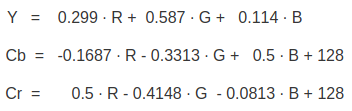

### After convertion all pixels are zero shifted. (Pixel values in range -128...128) Annex-A
A.3.1 Level shift
Before a non-differential frame encoding process computes the FDCT for a block of source image samples, the samples
shall be level shifted to a signed representation by subtracting 2P – 1, where P is the precision parameter specified in B.2.2.
Thus, when P = 8, the level shift is by 128; when P = 12, the level shift is by 2048.

In [3]:
def rgb2y(filename):
    """Returns Y component of an image

    Keyword arguments:
    filename -- image filename
    """
    _img_rgb = misc.imread(filename)
    _width, _height, _ = _img_rgb.shape
    _img_y = np.empty((_width, _height), dtype=np.float)
    _img_y[:, :] = (0.299 * _img_rgb[:, :, 0] + 0.587 * _img_rgb[:, :, 1] + 0.114 * _img_rgb[:, :,
                                                                                    2]) - 128.0  # Zero shifting
    return _img_y, _width, _height

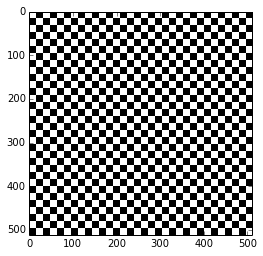

In [4]:
img_y, w, h = rgb2y(filename='./chess.bmp')

plt.imshow(img_y, cmap='gray')

## 3. Dividing Image to 8x8 Blocks and Applying DCT

In [5]:
def image2chunks2dct(image):
    """Returns 8X8 DCT applied blocks of an image

    Keyword arguments:
    image -- image to be divided into blocks
    """
    _dct_chunks = []
    _w, _h = image.shape
    l = _w * _h * 8 * 8
    for i in range(0, _w / 8):
        for j in range(0, _h / 8):
            _dct_chunks.append(dct(image[i * 8: i * 8 + 8, j * 8: j * 8 + 8], 2))
    return _dct_chunks

In [6]:
dct_chunks = image2chunks2dct(image=img_y)
dct_chunks[0]

array([[ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.],
       [ 2032.,     0.,     0.,     0.,     0.,     0.,     0.,     0.]])

In [7]:
img_y[0:8,0:8]

array([[ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.],
       [ 127.,  127.,  127.,  127.,  127.,  127.,  127.,  127.]])

## 4. Quantization
### Jpeg Standard Annex-K is defining the standard quantization tables for both Luminance and Chrominance Channels:

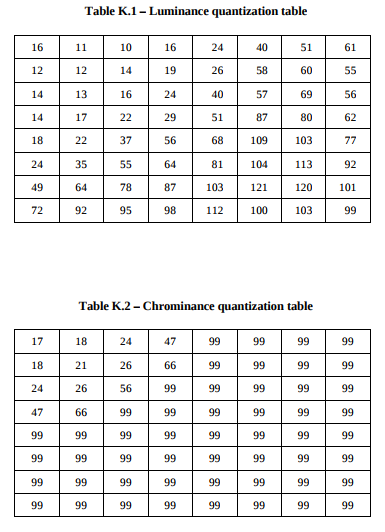

### Loading Quantization Matrices.

[Quantization Tables](https://www.impulseadventure.com/photo/jpeg-quantization.html)

In [8]:
import quantization_matrix as qm
qm.q_IrfanV_070

[[10, 7, 6, 10, 14, 24, 31, 37],
 [7, 7, 8, 11, 16, 35, 36, 33],
 [8, 8, 10, 14, 24, 34, 41, 34],
 [8, 10, 13, 17, 31, 52, 48, 37],
 [11, 13, 22, 34, 41, 65, 62, 46],
 [14, 21, 33, 38, 49, 62, 68, 55],
 [29, 38, 47, 52, 62, 73, 72, 61],
 [43, 55, 57, 59, 67, 60, 62, 59]]

In [9]:
def huff_q_table():
    """Returns Huffman coded quantization table"""
    huff_q=""
    for i in range(8):
        for j in range(8):
            huff_q+=huffmann_T1(qm.q_IrfanV_040[i][j])[2:]
            huff_q+=huffmann_T2(qm.q_IrfanV_040[i][j])[2:]
    return huff_q

In [10]:
def quantize(dct_chunks):
    """Returns quantized DCT blocks

    Keyword arguments:
    dct_chunks -- DCT blocks
    """
    _quant_chunks = []
    for dct_chunk in dct_chunks:
        temp = np.round(dct_chunk / qm.q_IrfanV_040)
        _quant_chunks.append(temp)
    return _quant_chunks

In [11]:
q_chunks = quantize(dct_chunks=dct_chunks)
q_chunks[0]

array([[ 102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 135.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 113.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 113.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  88.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  68.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  33.,    0.,    0.,    0.,    0.,    0.,    0.,    0.],
       [  23.,    0.,    0.,    0.,    0.,    0.,    0.,    0.]])

## 5. Zig-zag Scan Order

### Annex-A

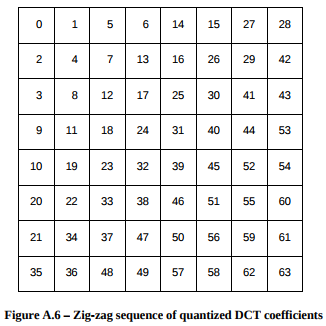

In [12]:
zz_order_list = [(0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2), (2, 1), (3, 0), (4, 0), (3, 1), (2, 2),
                 (1, 3), (0, 4), (0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2), (3, 3), (2, 4),
                 (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3),
                 (4, 4), (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3), (7, 2), (7, 3), (6, 4), (5, 5),
                 (4, 6), (3, 7), (4, 7), (5, 6), (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)]

In [13]:
def order_chunk(q_chunk):
    """Returns Zig-Zag scanned quantized blocks

    Keyword arguments:
    q_chunk -- Quantized block
    """
    _ordered_chunk = []
    for i in range(len(zz_order_list)):
        _ordered_chunk.append(q_chunk[zz_order_list[i]])  # for just one chunk
    return _ordered_chunk

## 6. Run Lenght Code

In [14]:
# I used the same code from https://www.techrepublic.com/article/run-length-encoding-in-python
# for this function
def run_length_code(ordered_chunk):
    """Returns Run Lenght Coded blocks

    Keyword arguments:
    ordered_chunk -- Zig-Zag scanned blocks
    """
    rlc = [(len(list(group)), name) for name, group in groupby(ordered_chunk)]
    return rlc

## 7. Huffman Coding
### Coding DC Coefficients

![DC Huffman](figures/Slide1.jpg)

### AC Coeffiencients

![AC Huffman](figures/Slide4.jpg)

The maximum length of run is limited to 15. Encoding of runs greater than 15
is done by a special symbol (15, 0), which is a run length of 15 zero coefficients
followed by a coefficient of zero amplitude. Hence, it can be interpreted as the
extension symbol with 16 zero coefficients. There can be up to three consecutive
(15, 0) symbols before the terminating symbol-1 followed by a single symbol-2.
For example, a (RUN  34, CAT  5) pair would result in three symbols a, b and c,
with a  (15, 0), b  (15, 0) and c  (2, 5).
An EOB is designated to indicate that the rest of the coefficients of the block in
the zigzag scanning order are quantised to zero. The EOB symbol is represented by
(RUN  0, CAT  0)

In [15]:
previous_dc = 0

In [16]:
def binbits(x, n):
    """Return binary representation of x with at least n bits"""
    bits = bin(x).split('b')[1]

    if len(bits) < n:
        return '0b' + '0' * (n - len(bits)) + bits

In [17]:
def huffmann_T1(amplitude):
    """Returns size for Huffman coding an amplitude

    Keyword arguments:
    amplitude -- Amplitude
    """
    size = int(math.log(abs(amplitude), 2)) + 1
    return huff_t1_df['Code'][size]

In [18]:
def huffmann_T2(amplitude):
    """Returns Huffman code for an DC amplitude

    Keyword arguments:
    amplitude -- DC Amplitude
    """
    size = int(math.log(abs(amplitude), 2)) + 1
    code = None
    if size == 0:
        code = None
    else:
        if amplitude > 0:
            to_code = pow(2, size - 1)
            code = bin((int(amplitude) - int(to_code)) | (1 << (size - 1)))
        else:
            to_code = pow(2, size) - 1
            code = binbits((to_code + amplitude), size)
    return code

In [19]:
def huffmann_T3(run,amplitude):
    """Returns Huffman code for an AC amplitude

    Keyword arguments:
    run       -- Run 
    amplitude -- AC Amplitude
    """
    size = int(math.log(abs(amplitude), 2)) + 1
    code = huff_t3_df['Code'][(huff_t3_df.Run== run) & (huff_t3_df.Size== size)]
    code = code.get_values()[0]
    return code

In [20]:
def huffman(rlc, p):
    """Returns Huffman coded bit array

    Keyword arguments:
    rlc -- Run Lenght Coded Coefficients
    p   -- Previous DC Coefficient
    """
    ba_block=""
    dc_s = None
    dc_c = None
    add_run = 0
    for i in range(len(rlc)):
        if i==0:
            if (rlc[i][1]-p)>0:
                dc_s = huffmann_T1((rlc[i][1]-p))
                dc_c = huffmann_T2((rlc[i][1]-p))
            p = rlc[i][1]
            if dc_c != None:
                ba_block += dc_s[2:]
                ba_block += dc_c[2:]
        if i>0:
            if rlc[i][1] == 0:
                add_run = rlc[i][0]
            else:
                if (rlc[i][0]+add_run)<16:
                    ac_h=huffmann_T3((rlc[i][0]+add_run),rlc[i][1])
                elif (rlc[i][0]+add_run)<31:
                    ac_h=huffmann_T3(1,rlc[i][1])
                elif (rlc[i][0]+add_run)<46:
                    ac_h=huffmann_T3(2,rlc[i][1])
                ba_block += ac_h[2:]
    eob = huff_t3_df['Code'][(huff_t3_df.Run== 0) & (huff_t3_df.Size== 0)]
    eob = eob.get_values()[0]
    ba_block += eob[2:]
    return ba_block, p

In [21]:
what_to_print=0
block_coded = ""
for q_chunk in q_chunks:
    ordered_chunk=order_chunk(q_chunk=q_chunk)
    rlc=run_length_code(ordered_chunk=ordered_chunk)
    huff_block, p =huffman(rlc,previous_dc)
    previous_dc = p
    if what_to_print==0:
        print("Zig-Zag Scanned Block")
        print(ordered_chunk)
        print("Run-Length Coded Block")
        print(rlc)
        print("Huffman Coding Block")
        print(huff_block)
    what_to_print+=1
    block_coded += huff_block

Zig-Zag Scanned Block
[102.0, 0.0, 135.0, 113.0, 0.0, 0.0, 0.0, 0.0, 0.0, 113.0, 88.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 68.0, 33.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 23.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Run-Length Coded Block
[(1, 102.0), (1, 0.0), (1, 135.0), (1, 113.0), (5, 0.0), (1, 113.0), (1, 88.0), (9, 0.0), (1, 68.0), (1, 33.0), (13, 0.0), (1, 23.0), (28, 0.0)]
Huffman Coding Block
11110110011011111111100011001111111110001011111111111010101011111111101010101111111111001100111111111100101111111111111011111010


In [22]:
def huff_h_table():
    """Returns Huffman coded Huffman table"""
    huff_h='00'
    for i in range(12):
        huff_h+=huffmann_T1(i+1)[2:]
        huff_h+=huffmann_T2(i+1)[2:]
    return huff_h

## 8. Write to A File

### [Markers](http://vip.sugovica.hu/Sardi/kepnezo/JPEG%20File%20Layout%20and%20Format.htm)


In [23]:
#Start of Image
SOI= b'FFD8'

#For JFIF File Format
JFIFAPP0 = b'FFE0'
JFIFLENGHTOFSEGMENT = b'0010'
JFIFIDENTIFIER=b'4A46494600'
JFIFVERSION=b'0102'
JFIFUNITS= b'00'
JFIFXDENSITY=b'0048'
JFIFYDENSITY=b'0048'
JFIFXTHUMBNAIL=b'00'
JFIFYTHUMBNAIL=b'00'

#Start of Frame
SOF0=b'FFC0'
SOF0LENGHT=b'0D'
DATAPRECISION=b'08'
WIDTH=b'0200'
HEIGHT=b'0200'
NCOMPONENTS=b'01'
SOFADD=b'010100'

#Define Huffman Table
HTABLE=b'FFC4'
HLENGTH=b'0243'
HIDENTITY=b'00'
huff_h=huff_h_table()

#Define Quantization Table
QTABLE=b'FFDB'
QLENGTH=b'0243'
QIDENTITY=b'00'
huff_q=huff_q_table()

#Start of Scan
SOS = b'FFDA'
SOSLENGHT=b'0008'
SOSADD=b'0100'
SOSADDMORE=b'000000'

#End of Image
EOI = b'FFD9'

binary_string =  binascii.unhexlify(SOI)

binary_string += binascii.unhexlify(JFIFAPP0)
binary_string += binascii.unhexlify(JFIFLENGHTOFSEGMENT)
binary_string += binascii.unhexlify(JFIFIDENTIFIER)
binary_string += binascii.unhexlify(JFIFVERSION)
binary_string += binascii.unhexlify(JFIFUNITS)
binary_string += binascii.unhexlify(JFIFXDENSITY)
binary_string += binascii.unhexlify(JFIFYDENSITY)
binary_string += binascii.unhexlify(JFIFXTHUMBNAIL)
binary_string += binascii.unhexlify(JFIFYTHUMBNAIL)

binary_string += binascii.unhexlify(SOF0)
binary_string += binascii.unhexlify(SOF0LENGHT)
binary_string += binascii.unhexlify(DATAPRECISION)
binary_string += binascii.unhexlify(HEIGHT)
binary_string += binascii.unhexlify(WIDTH)
binary_string += binascii.unhexlify(NCOMPONENTS)

binary_string += binascii.unhexlify(HTABLE)
binary_string += binascii.unhexlify(HLENGTH)
binary_string += binascii.unhexlify(HIDENTITY)
binary_string += huff_h

binary_string += binascii.unhexlify(QTABLE)
binary_string += binascii.unhexlify(QLENGTH)
binary_string += binascii.unhexlify(QIDENTITY)
binary_string += huff_q

binary_string += binascii.unhexlify(SOS)
binary_string += binascii.unhexlify(SOSLENGHT)
binary_string += binascii.unhexlify(NCOMPONENTS)
binary_string += binascii.unhexlify(SOSADD)
binary_string += binascii.unhexlify(SOSADDMORE)
binary_string += block_coded

binary_string += binascii.unhexlify(EOI)


In [24]:
with open("output.jpg", "wb") as outfile:
    outfile.write(binary_string)
    outfile.close()

In [26]:
out=misc.imread("output.jpg")

IOError: cannot identify image file

# [Github Repo: https://github.com/blgnksy/JpegEncoderPython](https://github.com/blgnksy/JpegEncoderPython)